# Image Processing

## Libraries
First of all, we include all libraries needed for this exercise.

In [3]:
import numpy as np
import cv2 as cv
import math
import pywt 
from matplotlib import pyplot as plt

Lena_img_path = "Lena.bmp"

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/majiddrn/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Exercise 1

The method discussed in the exercise, LoG, is mainly used as an approach which removes the effect of noise before laplacian application. By reversing the process, the result will be different. But to elaborate, We apply these two different approaches in several different ways.<br/>
**All approaches are by (5, 5) filter sizes**

First, we apply these two different approaches on grayscale image of `Lena`. We measure SSIM, PSNR and subtraction of two approaches.

In [4]:
lena_gray = cv.imread(Lena_img_path, cv.IMREAD_GRAYSCALE)

# As stated, we want the laplacian and gaussian filters, both with kernel size of (5, 5)
laplacian_kernel = np.array([[0, 1, 0, 1, 0],
                             [1, 1, 1, 1, 1],
                             [0, 1, -24, 1, 0],
                             [1, 1, 1, 1, 1],
                             [0, 1, 0, 1, 0]], dtype=np.float32)

# Firstly, applying LoG on the Lena image

blurred_lena_gray = cv.GaussianBlur(lena_gray, (5, 5), 0) # First applying gaussian
log_lena_gray = cv.Laplacian(blurred_lena_gray, cv.CV_64F, laplacian_kernel)


# Secondly, applying laplacian first, instead of gaussian.

laplacian_lena_gray = cv.Laplacian(blurred_lena_gray, cv.CV_64F, laplacian_kernel)
gol_lena_gray = cv.GaussianBlur(laplacian_lena_gray, (5, 5), 0)

Well, computation is over. Let's plot the result images.

Text(0.5, 1.0, 'First laplacian and then gaussian')

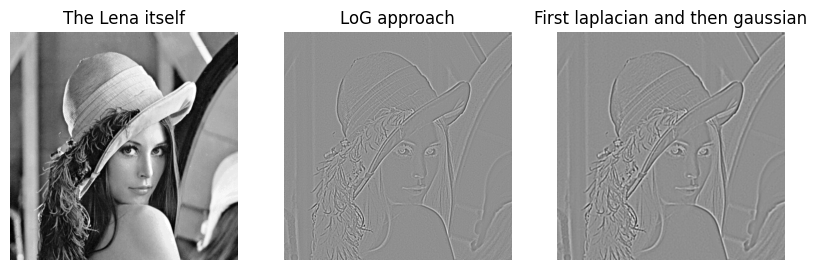

In [5]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 3, 1)

plt.imshow(lena_gray, cmap='gray')
plt.axis("off")
plt.title("The Lena itself")

fig.add_subplot(1, 3, 2)

plt.imshow(log_lena_gray,  cmap='gray')
plt.axis('off')
plt.title('LoG approach')

fig.add_subplot(1, 3, 3)

plt.imshow(gol_lena_gray,  cmap='gray')
plt.axis('off')
plt.title('First laplacian and then gaussian')


Great, we saw some differences between two approaches in two stated different implementations. But to make sure about it, let's measure PSNR, SSIM and difference of LoG and GoL.

The implementation of PSNR in code and mathematics is as follow.
$$
\text{PSNR} = 10 \cdot \log_{10}\left(\frac{{\text{MAX}^2}}{{\text{MSE}}}\right) 
$$
Which $MSE$ is mean square error.
$$
\text{SSIM}(x, y) = \frac{{(2 \mu_x \mu_y + C_1)(2 \sigma_{xy} + C_2)(\sigma_x^2 + \sigma_y^2 + C_3)}}{{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)(\sigma_x \sigma_y + C_3)}}
$$
<br/>
Code implementation credit: [CV Notes](https://cvnote.ddlee.cc/2019/09/12/psnr-ssim-python)

In [6]:
def calculate_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [7]:
def ssim(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

Well, let's calculate the PSNR and SSIM factors.<br/>
First to compare the LoG approach with the Lena image and then for GoL approach and Lena image itself comparsion.

In [8]:
psnr_log = calculate_psnr(log_lena_gray, lena_gray)
ssim_log = calculate_ssim(log_lena_gray, lena_gray)

psnr_gol = calculate_psnr(gol_lena_gray, lena_gray)
ssim_gol = calculate_ssim(gol_lena_gray, lena_gray)

print(f"For Lena and its LoG approach comparsion:\nPSNR:{psnr_log} and SSIM:{ssim_log}")
print("\n-----\n")
print(f"For Lena and its GoL approach comparsion:\nPSNR:{psnr_gol} and SSIM:{ssim_gol}")


For Lena and its LoG approach comparsion:
PSNR:5.814888863609525 and SSIM:-0.00022580376884029653

-----

For Lena and its GoL approach comparsion:
PSNR:5.833012211438813 and SSIM:0.0008247144778262229


While there is not much difference in PSNR factor, we can see a noteable difference in their SSIM factor which obviously shows us the difference between these two approaches.

Let's simply compute the subtraction of two approach results.

(-0.5, 511.5, 511.5, -0.5)

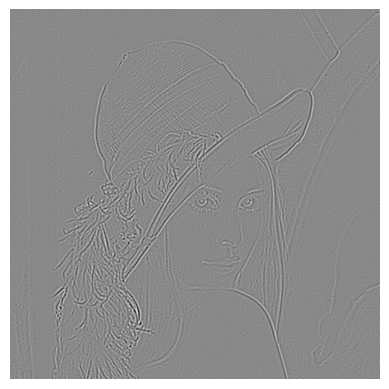

In [9]:
log_gol_lena_diff = log_lena_gray - gol_lena_gray

plt.imshow(log_gol_lena_diff, cmap='gray')
plt.axis('off')

The above difference, simply shows the result of LoG and GoL(Gaussian of Laplacian) are not the same.

Anyway, let's examine the computation on color image of Lena as well.

In [10]:
lena_color = cv.imread(Lena_img_path)

# LoG approach for colored Lena

lena_color_gaussian = cv.GaussianBlur(lena_color, (5, 5), 0)
log_lena_color = cv.Laplacian(lena_color_gaussian, cv.CV_64F, laplacian_kernel) # We have implemented the kernel above

# GoL approach for colored Lena

lena_color_laplacian = cv.Laplacian(lena_color, cv.CV_64F, laplacian_kernel)
gol_lena_color = cv.GaussianBlur(lena_color_laplacian, (5, 5), 0)

Computation is over now, let's plot the results.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'difference')

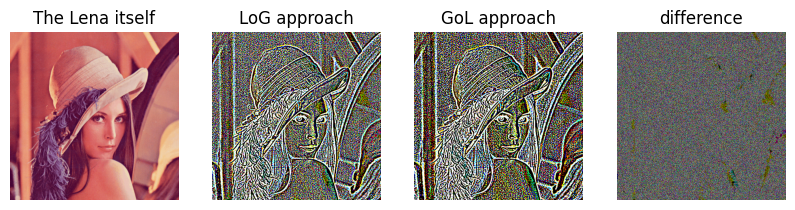

In [11]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 4, 1)

lena_color_rgb = cv.cvtColor(lena_color, cv.COLOR_BGR2RGB) # To have the lena_color in RGB space
plt.imshow(lena_color_rgb)
plt.axis("off")
plt.title("The Lena itself")

fig.add_subplot(1, 4, 2)

plt.imshow(log_lena_color)
plt.axis('off')
plt.title('LoG approach')

fig.add_subplot(1, 4, 3)

plt.imshow(gol_lena_color)
plt.axis('off')
plt.title('GoL approach')

fig.add_subplot(1, 4, 4)

plt.imshow(log_lena_color - gol_lena_color)
plt.axis('off')
plt.title('difference')


Well, we saw the two approaches difference in color images as well.

## Exercise 2
Clearly, applying the first derivation on the image gives us the edges. Horizontal derivation gives the vertical edges and vertical derivation gives us the horizontal edges.
<br/>
As stated, I myself will choose the first derivation vertically when I need the horizontal edges and I will use the first derivation horizontally when I need the vertical edges.

Text(0.5, 1.0, 'Horizontal derivation')

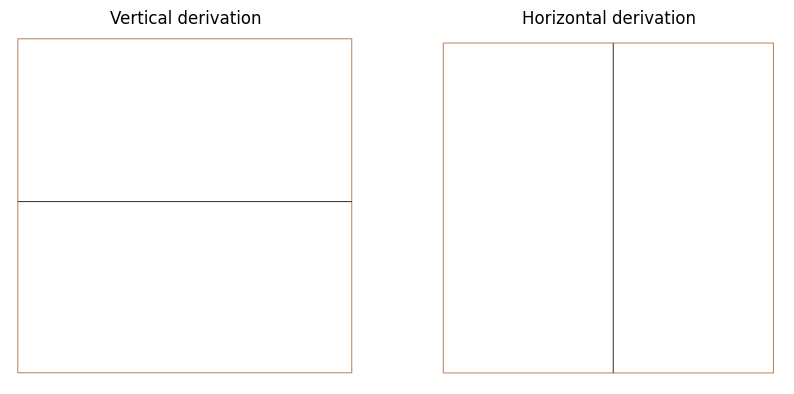

In [12]:
vertical_derivation_result = cv.imread('horizontal.png')
horizontal_derivation_result = cv.imread('vertical.png')

fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 2, 1)

plt.imshow(vertical_derivation_result, cmap='gray')
plt.axis("off")
plt.title("Vertical derivation")

fig.add_subplot(1, 2, 2)

plt.imshow(horizontal_derivation_result, cmap='gray')
plt.axis("off")
plt.title("Horizontal derivation")

To elaborate, let's examine in code.

First of all we should implement the kernel needed for first derivative application and a function for convolution.

In [13]:
def convolution(img, kernel):
    width, height = img.shape
    width_k, height_k = kernel.shape

    output_height = height - height_k + 1
    output_width = width - width_k + 1

    output = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            summation = np.sum(img[i:i + height_k, j:j + width_k] * kernel)
            output[i, j] = summation

    return output


Well, let's apply the horizontal derivation and vertical derivation on the image.

In [14]:
first_derivative_kernel_vertical = np.array([[1, 2, 1],
                                               [0, 0, 0],
                                               [-1, -2, -1]])
first_derivative_kernel_horizontal = np.array([[-1, 0, 1],
                                               [-2, 0, 2],
                                               [-1, 0, 1]])
square_gray = cv.imread('squre.png', cv.IMREAD_GRAYSCALE)

first_derivative_horizontal_output = convolution(img=square_gray, kernel=first_derivative_kernel_horizontal)
first_derivative_vertical_output = convolution(img=square_gray, kernel=first_derivative_kernel_vertical)

Now, let's simply plot the results.

Text(0.5, 1.0, 'Vertical derivation')

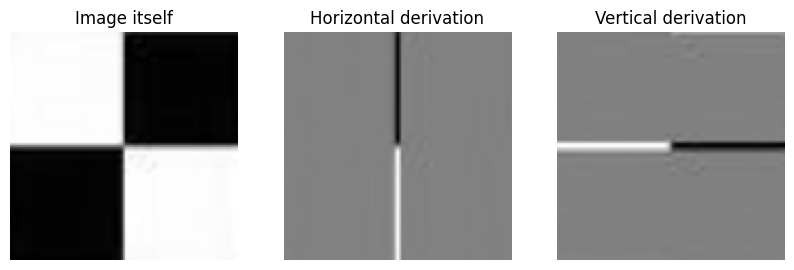

In [15]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 3, 1)

plt.imshow(square_gray, cmap='gray')
plt.axis("off")
plt.title("Image itself")

fig.add_subplot(1, 3, 2)

plt.imshow(first_derivative_horizontal_output, cmap='gray')
plt.axis("off")
plt.title("Horizontal derivation")

fig.add_subplot(1, 3, 3)

plt.imshow(first_derivative_vertical_output, cmap='gray')
plt.axis("off")
plt.title("Vertical derivation")

Well, We saw the results are as expected.

## Exercise 3
First of all we should compute the frequency of each gray scale in the image. After that, the probablity and PDF of each. Finally, by multiplying each PDF by 255(which is L-1), we can have new intensities. <br/>

| Gray Level      | Frequency | Probability | PDF | $PDF \times 255 = $ new gray level |
| ----------- | ----------- | ----------- | -----------| ----------- |
| 25 | 1 | $\frac{1}{15}$ | $\frac{1}{15}$ | 17 |
| 30 | 1 | $\frac{1}{15}$ | $\frac{2}{15}$ | 34 |
| 40 | 1 | $\frac{1}{15}$ | $\frac{3}{15}$ | 51 |
| 45 | 1 | $\frac{1}{15}$ | $\frac{4}{15}$ | 68 |
| 55 | 1 | $\frac{1}{15}$ | $\frac{5}{15}$ | 85 |
| 65 | 1 | $\frac{1}{15}$ | $\frac{6}{15}$ | 102 |
| 70 | 1 | $\frac{1}{15}$ | $\frac{7}{15}$ | 119 |
| 80 | 1 | $\frac{1}{15}$ | $\frac{8}{15}$ | 136 |
| 95 | 1 | $\frac{1}{15}$ | $\frac{9}{15}$ | 153 |
| 110 | 1 | $\frac{1}{15}$ | $\frac{10}{15}$ | 170 |
| 120 | 1 | $\frac{1}{15}$ | $\frac{11}{15}$ | 187 |
| 150 | 1 | $\frac{1}{15}$ | $\frac{12}{15}$ | 204 |
| 175 | 1 | $\frac{1}{15}$ | $\frac{13}{15}$ | 221 |
| 180 | 1 | $\frac{1}{15}$ | $\frac{14}{15}$ | 238 |
| 200 | 1 | $\frac{1}{15}$ | $\frac{15}{15}=1$ | 255 |

The image before and after equalization is as follow. 


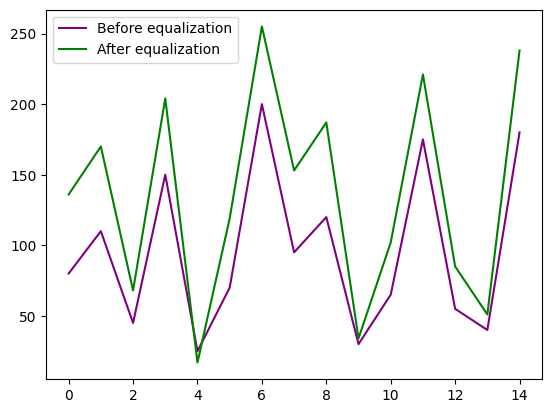

In [16]:
image_before_equal = np.array([80, 110, 45, 150, 25, 70, 200, 95, 120, 30, 65, 175, 55, 40, 180])
image_after_equal = np.array([136, 170, 68, 204, 17, 119, 255, 153, 187, 34, 102, 221, 85, 51, 238])

plt.plot(image_before_equal, color='purple', label='Before equalization')
plt.plot(image_after_equal, color='green', label='After equalization')
plt.legend(loc='upper left')

## Exercise 4
In wavelet transform, we try to have both frequency and spatial information of the image with the least cost. As a result, there would be a kernel with a variable size, moving across the signal(here, the signal is our image). <br/>
The kernel computes the frequency of each area it consists in every iteration. One important factor in the iteration is that the size of wavelet window is dependent on the resolution and frequency of that area. If the area has high frequencies, the window size will be wider. Otherwise, if the area has lower frequencies, the spatial information to be remained, window size will be narrower. Well, It was simply the decomposition phase.<br/>

![Wavelet](WaveletDecompose.png)

After decomposition, we have a set of wavelet coefficients. Quantization is the process of mapping these coefficients to a smaller set of values, which can be represented with fewer bits.<br/>

## Exercise 5
To downsample the image, we simply drop rows/columns decussately. To acheive this goal, we implement a function for the rest.

In [17]:
def downsample2(img):    
    rows_keep = img.shape[0] // 2
    cols_keep = img.shape[1] // 2

    downsampled_img = img[:rows_keep * 2, :cols_keep * 2]
    downsampled_img = downsampled_img.reshape((rows_keep, 2, cols_keep, 2))
    downsampled_img = downsampled_img.mean(axis=(1, 3))

    return downsampled_img

Now, let's impelement a function for upsampling the image with the replication or bilinear interpolation method.

In [18]:
def upsample2(img, method):
    upsampled_img = np.zeros((img.shape[0] * 2, img.shape[1] * 2), dtype=img.dtype)
    img_ = img.astype(np.float64)

    if method == 'replication':
        for i in range(img_.shape[0]):
            for j in range(img_.shape[1]):
                upsampled_img[i * 2, j * 2] = img_[i, j]
                upsampled_img[i * 2 + 1, j * 2] = img_[i, j]
                upsampled_img[i * 2, j * 2 + 1] = img_[i, j]
                upsampled_img[i * 2 + 1, j * 2 + 1] = img_[i, j]
    elif method == 'bilinear':
        for i in range(img_.shape[0]):
            for j in range(img_.shape[1]):
                upsampled_img[i * 2, j * 2] = img_[i, j]

                # Handle the last column and last row separately
                if j < img_.shape[1] - 1:
                    upsampled_img[i * 2, j * 2 + 1] = (img_[i, j] + img_[i, j + 1]) / 2
                else:
                    upsampled_img[i * 2, j * 2 + 1] = img_[i, j]

                if i < img_.shape[0] - 1:
                    upsampled_img[i * 2 + 1, j * 2] = (img_[i, j] + img_[i + 1, j]) / 2
                else:
                    upsampled_img[i * 2 + 1, j * 2] = img_[i, j]

                if i < img_.shape[0] - 1 and j < img_.shape[1] - 1:
                    upsampled_img[i * 2 + 1, j * 2 + 1] = (img_[i, j] + img_[i + 1, j] + img_[i, j + 1] + img_[i + 1, j + 1]) / 4
                elif i < img_.shape[0] - 1:
                    upsampled_img[i * 2 + 1, j * 2 + 1] = (img_[i, j] + img_[i + 1, j]) / 2
                elif j < img_.shape[1] - 1:
                    upsampled_img[i * 2 + 1, j * 2 + 1] = (img_[i, j] + img_[i, j + 1]) / 2
                else:
                    upsampled_img[i * 2 + 1, j * 2 + 1] = img_[i, j]

    return upsampled_img

Well, let's pass the Lena image to the functions above.

In [19]:
lena_downsampled2 = downsample2(lena_gray)

lena_upsampled2_replication = upsample2(lena_gray, 'replication') # First with the replication method
lena_upsampled2_bilinear = upsample2(lena_gray, 'bilinear') # Then with the bilinear interpolation method

Now, let's plot the results.

Text(0.5, 1.0, 'Bilinear interpolation method')

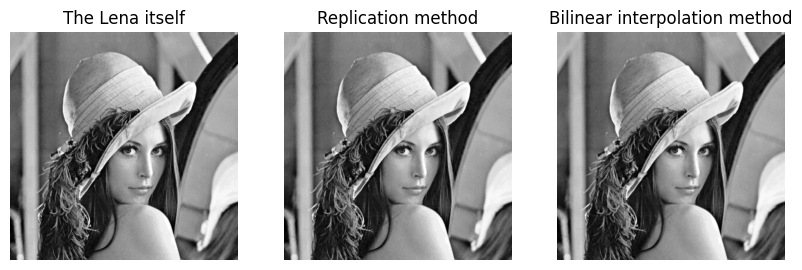

In [20]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 3, 1)

plt.imshow(lena_gray, cmap='gray')
plt.axis("off")
plt.title("The Lena itself")

fig.add_subplot(1, 3, 2)

plt.imshow(lena_upsampled2_replication, cmap='gray')
plt.axis('off')
plt.title('Replication method')

fig.add_subplot(1, 3, 3)

plt.imshow(lena_upsampled2_bilinear, cmap='gray')
plt.axis('off')
plt.title('Bilinear interpolation method')

Let's simply compute the difference of two method results.

(-0.5, 1023.5, 1023.5, -0.5)

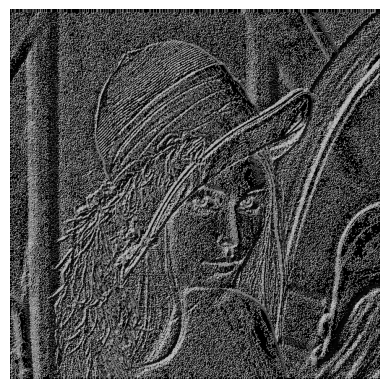

In [21]:
plt.imshow(lena_upsampled2_replication - lena_upsampled2_bilinear, cmap='gray')
plt.axis("off")

The difference, obviously shows that the two methods have noteable differences.

## Exercise 6
In this exercise, we simply use the previous convolution function implemented for the spatial domain. And for the fourier computations, we simply implement the following function to calculate the fourier transform of any filter.

In [22]:
def fourier__magnitude(img_in, shape=(0, 0)):
    if (shape == (0, 0)):
        fdft = np.fft.fft2(img_in)
    else:
        fdft = np.fft.fft2(img_in, shape)
    fdftshift = np.fft.fftshift(fdft)
    magnitude_spectrum_fdft = np.log(np.abs(fdftshift))
    return (fdftshift, magnitude_spectrum_fdft)

def fourier__pad_kernel(kernel, new_size):
    fdftshift__kernel,_ = fourier__magnitude(kernel, new_size)

    return fdftshift__kernel


Now, let's implement a function to compute the application of a the filters on the image in frequency domain.

In [23]:
def apply_filter_freq(img, kernel):
    img__,_  = fourier__magnitude(img)

    result_freq = img__ * kernel

    return np.uint8(np.abs(np.fft.ifft2(np.fft.ifftshift(result_freq))))

Now, with the help of the functions we implemented before, let's apply the filters on the image.

In [24]:
# We simply implement the kernels we need

kernel_A = np.array([[1/9, 1/9, 1/9],
                     [1/9, 1/9, 1/9],
                     [1/9, 1/9, 1/9]])

kernel_B = np.array([[-1, -1, -1],
                     [-1,  8, -1],
                     [-1, -1, -1]])

kernel_C = np.array([[0, -1,  0],
                     [-1, 5, -1],
                     [0, -1,  0]])


# Now, let's apply the kernel A on the Lena image with two spatial and fourier approaches

kernel_A_fourier = fourier__pad_kernel(kernel_A, lena_gray.shape)

lena__A_spatial_builtin = cv.filter2D(lena_gray, -1, kernel_A)
lena__A_fourier = apply_filter_freq(lena_gray, kernel_A_fourier)

# Now, let's apply the kernel B on the Lena image with two spatial and fourier approaches

kernel_B_fourier = fourier__pad_kernel(kernel_B, lena_gray.shape)

lena__B_spatial_builtin = cv.filter2D(lena_gray, -1, kernel_B)
lena__B_fourier = apply_filter_freq(lena_gray, kernel_B_fourier)


# Now, let's apply the kernel C on the Lena image with two spatial and fourier approaches

kernel_C_fourier = fourier__pad_kernel(kernel_C, lena_gray.shape)

lena__C_spatial_builtin = cv.filter2D(lena_gray, -1, kernel_C)
lena__C_fourier = apply_filter_freq(lena_gray, kernel_C_fourier)


/tmp/ipykernel_4642/1749126714.py:7: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum_fdft = np.log(np.abs(fdftshift))


Now, let's plot the result of applying kernel A on the image in both spatial and frequency domain.

Text(0.5, 1.0, 'Box filter freq')

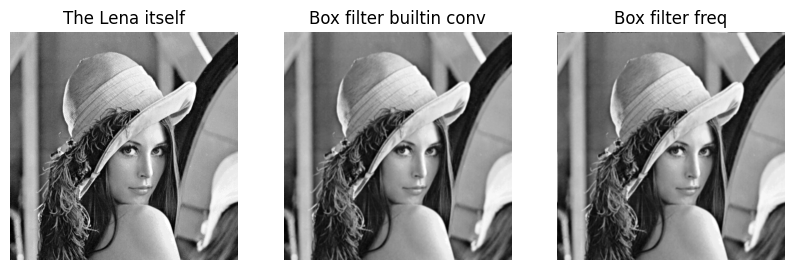

In [25]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 3, 1)

plt.imshow(lena_gray, cmap='gray')
plt.axis("off")
plt.title("The Lena itself")

fig.add_subplot(1, 3, 2)

plt.imshow(lena__A_spatial_builtin, cmap='gray')
plt.axis('off')
plt.title('Box filter builtin conv')

fig.add_subplot(1, 3, 3)

plt.imshow(lena__A_fourier, cmap='gray')
plt.axis('off')
plt.title('Box filter freq')

Now, it's the kernel B turn.

Text(0.5, 1.0, 'Laplacian freq')

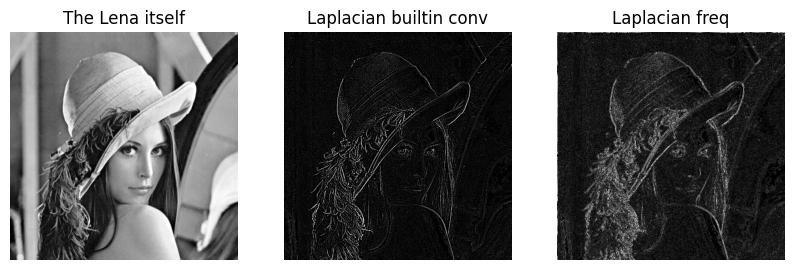

In [26]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 3, 1)

plt.imshow(lena_gray, cmap='gray')
plt.axis("off")
plt.title("The Lena itself")

fig.add_subplot(1, 3, 2)

plt.imshow(lena__B_spatial_builtin, cmap='gray')
plt.axis('off')
plt.title('Laplacian builtin conv')

fig.add_subplot(1, 3, 3)

plt.imshow(lena__B_fourier, cmap='gray')
plt.axis('off')
plt.title('Laplacian freq')

And finally, it's the kernel C's turn which is a simple sharpenning kernel.

Text(0.5, 1.0, 'Sharpenning freq')

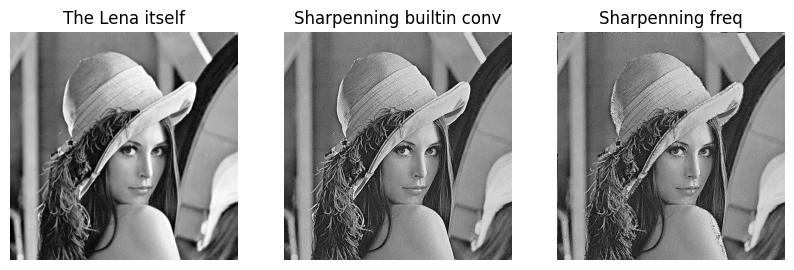

In [27]:
fig = plt.figure(figsize=(10, 7))

fig.add_subplot(1, 3, 1)

plt.imshow(lena_gray, cmap='gray')
plt.axis("off")
plt.title("The Lena itself")

fig.add_subplot(1, 3, 2)

plt.imshow(lena__C_spatial_builtin, cmap='gray')
plt.axis('off')
plt.title('Sharpenning builtin conv')

fig.add_subplot(1, 3, 3)

plt.imshow(lena__C_fourier, cmap='gray')
plt.axis('off')
plt.title('Sharpenning freq')

## Exercise 7
We have the box filter as follow.
$$
K=
\begin{pmatrix}
\frac{1}{4} & \frac{1}{4} \\
\frac{1}{4} & \frac{1}{4}
\end{pmatrix}
$$
Let's make the pyramid as wanted.

In [28]:
kernel__average22 = np.array([[1/4, 1/4],
                            [1/4, 1/4]])

img__L1 = lena_gray
approx__L1 = downsample2(cv.filter2D(img__L1, -1, kernel__average22))
prediction__L1 = img__L1 - upsample2(approx__L1, 'replication')

img__L2 = approx__L1
approx__L2 = downsample2(cv.filter2D(img__L2, -1, kernel__average22))
prediction__L2 = img__L2 - upsample2(approx__L2, 'replication')

img__L3 = approx__L2
approx__L3 = downsample2(cv.filter2D(img__L3, -1, kernel__average22))
prediction__L3 = img__L3 - upsample2(approx__L3, 'replication')

Computation is over, let's plot the pyramid.

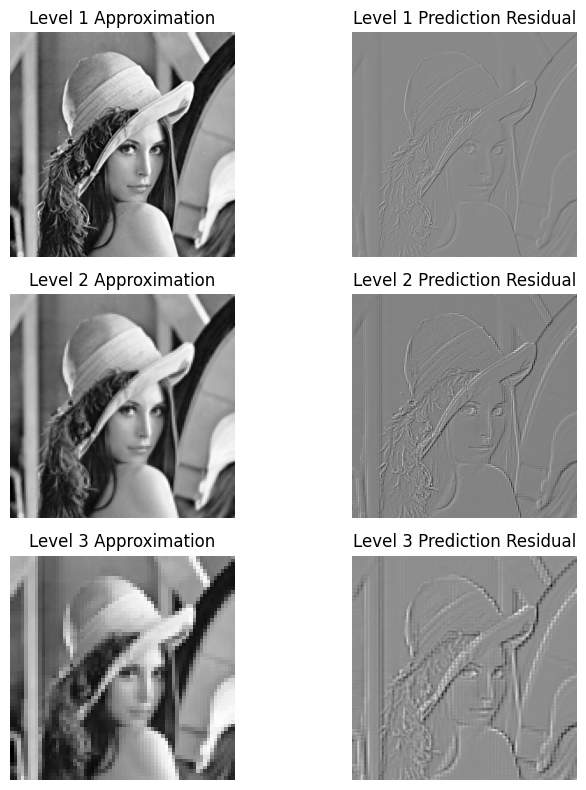

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))

approximation_pyramid = [approx__L1, approx__L2, approx__L3]
prediction_residual_pyramid = [prediction__L1, prediction__L2, prediction__L3]

for level in range(3):
    axes[level, 0].imshow(approximation_pyramid[level], cmap='gray')
    axes[level, 0].set_title(f'Level {level+1} Approximation')

    axes[level, 1].imshow(prediction_residual_pyramid[level], cmap='gray')
    axes[level, 1].set_title(f'Level {level+1} Prediction Residual')

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

## Exercise 8


To acheive this goal, we simply install the library `pywt`. After the installation, usage is so easy. We store every level as follow.

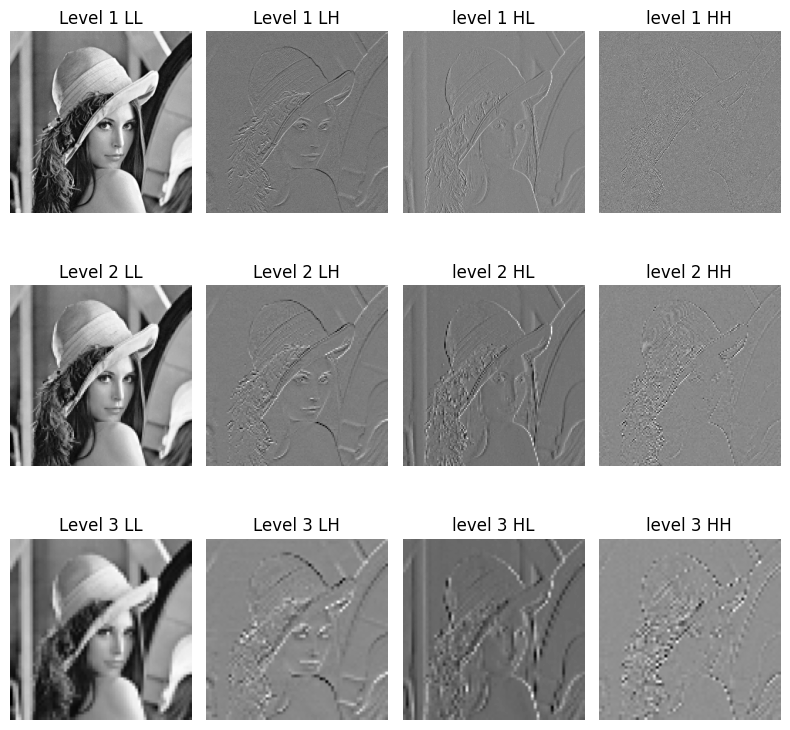

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 8))

img__LL = lena_gray

for level in range(3):
    coeffs = pywt.dwt2(img__LL, 'haar')
    cA, (cH, cV, cD) = coeffs

    axes[level, 0].imshow(cA, cmap='gray')
    axes[level, 0].set_title(f'Level {level+1} LL')

    axes[level, 1].imshow(cH, cmap='gray')
    axes[level, 1].set_title(f'Level {level+1} LH')

    axes[level, 2].imshow(cV, cmap='gray')
    axes[level, 2].set_title(f'level {level+1} HL')

    axes[level, 3].imshow(cD, cmap='gray')
    axes[level, 3].set_title(f'level {level+1} HH')

    img__LL = cA

for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

Well, let's discuss on the differences.
+ The wavelet transform, gives more infromation which contains vertical, horizontal and diagonal edges. While, the pyramid in the 7th question, doesn't give us horizontal or vertical edges seperately.

+ The Haar wavelet transform provides a multi-resolution representation of the image, prepares both low-frequency and high-frequency details at different scales. This is useful for some image processing tasks, such as compression, denoising and feature extraction.

+ Clearly, the Haar wavelet transform offers a more sophisticated analysis of the image content compared to a simple 2x2 filter.